# import packages sklearn & dataset Sign_Language_MNIST

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
!pwd
%cd /content/drive/MyDrive/Sign_Language_MNIST
!pwd

/content
/content/drive/MyDrive/Sign_Language_MNIST
/content/drive/MyDrive/Sign_Language_MNIST


In [ ]:
# The erros comes with the new version of xgboost
# ValueError: y should be a 1d array, got an array of shape (27455, 785) instead.

# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# train = le.fit_transform(train)

# xgboost version 要小 
!pip uninstall xgboost 
!pip install xgboost==1.2.1

In [ ]:
import xgboost
print( xgboost.__version__ )

In [6]:
%matplotlib inline
import time

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns 
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.manifold import TSNE


In [7]:
train = pd.read_csv('sign_mnist_train.csv')
# train.head(10)

# print(train_data.shape)
# print(test_data.shape)  # 单个28x28像素图像

test = pd.read_csv('sign_mnist_test.csv')
# test.head(10)

In [26]:
# Split data

X_train = train.drop(columns='label') # 784 pixels  train.drop(['label'], axis=1)
y_train = train['label'] # label

X_test = test.drop(columns='label')
y_test = test['label']

label_index = 'ABCDEFGHIKLMNOPQRSTUVWXY'
labels = np.unique(np.array(y_train))
print(labels)
# X_train.shape

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


# PCA dimension reduction

In [ ]:
# Find the optimal value of n_components
data_line = PCA().fit(X_train)
data_line.explained_variance_ratio_
print(data_line.explained_variance_ratio_)
np.cumsum(data_line.explained_variance_ratio_)
print(np.cumsum(data_line.explained_variance_ratio_))

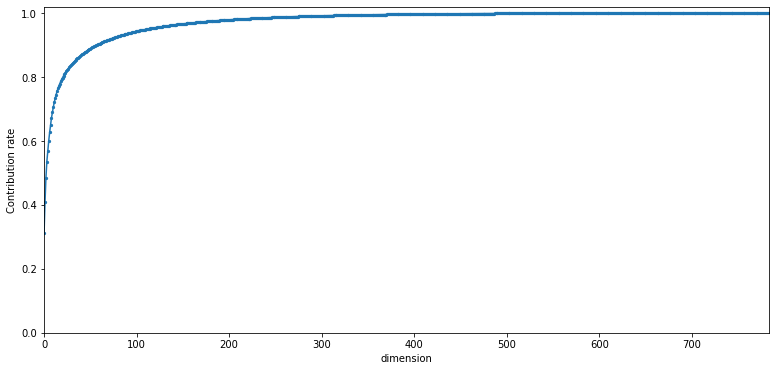

In [ ]:
# Draw a cumulative contribution rate graph
plt.figure(figsize=(13, 6))

plt.plot(range(0,784), np.cumsum(data_line.explained_variance_ratio_)) # 绘制主成分累积比例图
plt.scatter(range(0,784),np.cumsum(data_line.explained_variance_ratio_),s=5)
plt.xlim(0, 784)
plt.ylim(0, 1.02)

plt.xlabel('dimension')
plt.ylabel('Contribution rate')

plt.show()

# 根据图所示，n_components可以是400,500左右

In [ ]:
# PCA dimension reduction

pca = decomposition.PCA() 
pca.n_components = 500  # 降维后保留的特征数量
pca_data = pca.fit_transform(X_train/255)

print('shape of pca_reduced.shape = ', pca_data.shape)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

pca_data = np.vstack((pca_data.T, y_train)).T

In [ ]:
# 二维的时候可以
# pca_df = pd.DataFrame(pca_data, columns=('PC 1', 'PC 2', 'label'))
# pca_df.head()

In [ ]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca, X_test_pca)

# Visualizing PCA 二维的时候可以绘图
# sns.FacetGrid(pca_df, hue='label', height=8).map(plt.scatter, 'PC 1', "PC 2").add_legend()

# Xgboost

In [28]:
# XGBClassifier

# param['gpu_id'] = 0
# param['tree_method'] = 'gpu_hist'

start_time = time.time()
print(start_time)

# 没PCA降维预处理
xgb = XGBClassifier(learning_rate=0.25)

# Fit the model using predictor X and response y.
xgb.fit(X_train, y_train)

print('*'*20)
print('XGB Classifier')
print(f'accuracy of train set xgb.score: {xgb.score(X_train, y_train)}')
print(f'accuracy of test set xgb.score: {xgb.score(X_test, y_test)}')

# PCA降维之后 准确率低了很多
# xgb_pca = XGBClassifier()
# xgb_pca.fit(X_train_pca, y_train)

# print('Fit time : ', time.time() - start_time)
# print('*'*20)
# print('XGB_PCA Classifier')
# print(f'accuracy of train set xgb_pca.score: {xgb_pca.score(X_train_pca, y_train)}')
# print(f'accuracy of test set xgb_pca.score: {xgb_pca.score(X_test_pca, y_test)}')

1679470359.896251


/usr/local/lib/python3.9/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


********************
XGB Classifier
accuracy of train set xgb.score: 1.0


/usr/local/lib/python3.9/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


accuracy of test set xgb.score: 0.770914668153932


# GridSearchCV Tuning parameters for Xgboost

In [ ]:
# GridSearchCV 调参  很慢。。

from sklearn.model_selection import GridSearchCV

def Tuning(cv_params, other_params):
    model = XGBClassifier(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, cv=5, n_jobs=4)
    optimized_GBM.fit(X_train, y_train)
    # evalute_result = optimized_GBM.grid_scores_

    # print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

# 往Tuning中输入两个参数，cv_params，和other_params，前面指的你要调优的参数，后面指的其他的参数

cv_params = {'max_depth':[5,6,7]} # 'max_depth':[5,6,7]   
# learning_rate：0.25最佳； [0.2,0.25,0.3]:0.25最佳,[0.01,0.05,0.1]:0.1最佳,[0.1,0.15,0.2]:0.2最佳
other_params = {
    'eta':0.3,  # 如同学习率
    'learning_rate':0.25, # 过拟合降低学习率,欠拟合加大学习率. 典型值一般设置为：0.01-0.2
    'n_estimators':100, # 需调参  number of trees 默认100
    'max_depth':6, # 需调参 默认值为6，建议3-10
    'min_child_weight':1, # 需调参 
    'gamma':0, # 需调参 gamma值越大，算法越保守
    'subsample':1, # range: (0,1] 需调参 Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees.
    'colsample_bytree':0.8, # 需调参 
    # 'scale_pos_weight':1, # Control the balance of positive and negative weights, useful for unbalanced classes
    'objective':'multi:softmax',  # 多分类的问题
    'num_class':24,  # 类别数，与 multisoftmax 并用
}
Tuning(cv_params, other_params)  # 一个调节完毕之后，相应改动other_params中的参数设置即可

# Adaboost

In [ ]:
# AdaBoostClassifier默认使用CART分类树DecisionTreeClassifier
# scikit-learn实现了两种Adaboost分类算法，SAMME和SAMME.R。两者的主要区别是弱学习器权重的度量，SAMME使用对样本集分类效果作为弱学习器权重，而SAMME.R使用了对样本集分类的预测概率大小来作为弱学习器权重。由于SAMME.R使用了概率度量的连续值，迭代一般比SAMME快，因此AdaBoostClassifier的默认算法algorithm的值也是SAMME.R。
# Adaboost不进行样本和特征的抽样，会用全部样本和特征来建立每一个基学习器
# 参数 AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None) 

# AdaBoostClassifier相关参数：
# base_estimator：基本分类器，默认为DecisionTreeClassifier(max_depth=1)
# n_estimators：终止迭代的次数
# learning_rate：学习率
# algorithm：训练的相关算法，{'SAMME'，'SAMME.R'}，默认='SAMME.R'
# random_state：随机种子

In [21]:
start_time = time.time()

AdaB_cl = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=7), n_estimators=120, learning_rate=0.2) # base_estimator = tree.DecisionTreeClassifier(max_depth=6), random_state=1
AdaB_cl.fit(X_train, y_train) # Fit the model using predictor X and response y

print('Fit time : ', time.time() - start_time)
print('*'*20)

print('AdaBoostClassifier')
print(f'accuracy of train set AdaBoost.score: {AdaB_cl.score(X_train, y_train)}')
print(f'accuracy of test set AdaBoost.score: {AdaB_cl.score(X_test, y_test)}')

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fit time :  1385.315383195877
********************
AdaBoostClassifier
accuracy of train set AdaBoost.score: 0.9994536514296121
accuracy of test set AdaBoost.score: 0.7051031790295594


# GridSearchCV Tuning parameters for Adaboost

In [ ]:
# GridSearchCV 调参 

from sklearn.model_selection import GridSearchCV

def Tuning(cv_params, other_params):
    model = AdaBoostClassifier(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, cv=5, n_jobs=4)
    optimized_GBM.fit(X_train, y_train)
    # evalute_result = optimized_GBM.grid_scores_

    # print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

# 往Tuning中输入两个参数，cv_params，和other_params，前面指的你要调优的参数，后面指的其他的参数

cv_params = {'n_estimators':[100,150,200]} # 'learning_rate':[0.2,0.25,0.275,0.3],
# learning_rate 
other_params = {
    'learning_rate':0.25, # 过拟合降低学习率,欠拟合加大学习率. 典型值一般设置为：0.01-0.2
    'n_estimators':100, # 需调参 
    'base_estimator':DecisionTreeClassifier(max_depth=7),
}
Tuning(cv_params, other_params)  # 一个调节完毕之后，相应改动other_params中的参数设置即可

# Result report


**XGBoost**

*When using PCA to reduce dimension to 400:*

accuracy of train set xgb_pca.score: 1.0; accuracy of test set xgb_pca.score: 0.6565811489124372

*no PCA preprocessing：*

accuracy of train set: 1.0; accuracy of test set: 0.770914668153932

According to the results, after PCA dimension reduction, the accuracy rate is lower. So the following adaboost does not use PCA dimension reduction.

Parameters tuning with GridSearchCV is too time-consuming. Only a small amount of parameters tuning was done.

**AdaBoost**

*no PCA preprocessing：*

accuracy of train set: 0.9994536514296121;  
accuracy of test set: 0.7051031790295594



# True Positive Matrix


## AdaBoostClassifier TP Matrix

In [22]:
pred_label_test_AdaB = AdaB_cl.predict(X_test)

In [23]:
label_df_AdaB = pd.DataFrame({
    'True': y_test,
    'Pred': pred_label_test_AdaB
})

In [24]:
# get True Positive for each label
def cal_TP_matrix(label_df):
    TP_matrix = np.zeros((24,24))

    for lb in labels:
        ture_count = label_df.loc[label_df['True'] == lb].groupby('Pred').agg(
            'count')
        for pred_idx, row in ture_count.iterrows():
            lb_idx = lb if lb < 9 else lb-1
            pred_idx = pred_idx if pred_idx < 9 else pred_idx-1
            TP_matrix[lb_idx][pred_idx] = row[0]

    return TP_matrix

def cal_TPR(label_df):
    RP = label_df.groupby('True').agg('count')
    PP = label_df.groupby('Pred').agg('count')
    TP = label_df.loc[label_df['True']==label_df['Pred']].groupby('True').agg('count')
    
    precision = np.array(TP).T[0] / np.array(PP).T[0]
    recall = np.array(TP).T[0] / np.array(RP).T[0]
    return precision, recall
    

cal_TPR(label_df_AdaB)


(array([0.96710526, 1.        , 0.99658703, 0.7992278 , 0.91169451,
        0.72929936, 0.84542587, 0.94609164, 0.64814815, 0.84158416,
        0.83690987, 0.71147541, 0.45801527, 1.        , 0.93393393,
        0.80434783, 0.15932914, 0.34625323, 0.5559322 , 0.58008658,
        0.45620438, 0.38024691, 0.80213904, 0.75088968]),
 array([0.88821752, 0.81018519, 0.94193548, 0.84489796, 0.76706827,
        0.92712551, 0.77011494, 0.80504587, 0.72916667, 0.51359517,
        0.93301435, 0.55076142, 0.41237113, 0.67073171, 0.8962536 ,
        0.90243902, 0.52777778, 0.54471545, 0.66129032, 0.5037594 ,
        0.36127168, 0.74757282, 0.56179775, 0.63554217]))

In [27]:
pd.options.display.max_columns = None

label_index = [i for i in label_index]
TPmx = cal_TP_matrix(label_df_AdaB)
pd.DataFrame(TPmx, label_index, label_index)

,A,B,C,D,E,F,G,H,I,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y
A,294.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,14.0,8.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0
B,0.0,350.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,6.0,9.0,45.0,0.0,0.0
C,0.0,0.0,292.0,0.0,0.0,11.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
D,0.0,0.0,0.0,207.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0,0.0,0.0,0.0,10.0,0.0,0.0,5.0,11.0,4.0,0.0,0.0
E,3.0,0.0,0.0,0.0,382.0,1.0,0.0,0.0,0.0,0.0,0.0,17.0,28.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,7.0
F,0.0,0.0,0.0,0.0,0.0,229.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,0.0,2.0,2.0,0.0,0.0
G,0.0,0.0,0.0,3.0,0.0,0.0,268.0,12.0,9.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,12.0,0.0,23.0,0.0,7.0,0.0,0.0,0.0
H,0.0,0.0,0.0,1.0,0.0,2.0,31.0,351.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,2.0,3.0,0.0,17.0,7.0,6.0,2.0,0.0,5.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.0,0.0,0.0,7.0,11.0,0.0,0.0,4.0,9.0,16.0,0.0,0.0,12.0,2.0,0.0,17.0
K,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,11.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,7.0,0.0,19.0,2.0,39.0,1.0,6.0


## XgBoostClassifier TP Matrix

In [29]:

pred_label_test_xgb = xgb.predict(X_test)

label_df_xgb = pd.DataFrame({
    'True': y_test,
    'Pred': pred_label_test_xgb
})

/usr/local/lib/python3.9/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [30]:
cal_TPR(label_df_xgb)

(array([0.84920635, 0.98473282, 0.92857143, 0.87956204, 0.85742188,
        0.76975945, 0.89361702, 0.98267327, 0.85714286, 0.79522184,
        0.78277154, 0.76510067, 0.76404494, 0.94186047, 0.95454545,
        0.60784314, 0.25210084, 0.45722714, 0.57094595, 0.58823529,
        0.79296875, 0.49280576, 0.76639344, 0.68013468]),
 array([0.96978852, 0.89583333, 0.92258065, 0.98367347, 0.8815261 ,
        0.90688259, 0.84482759, 0.91055046, 0.6875    , 0.70392749,
        1.        , 0.5786802 , 0.46735395, 0.65853659, 0.96829971,
        0.94512195, 0.41666667, 0.6300813 , 0.68145161, 0.63909774,
        0.5867052 , 0.66504854, 0.70037453, 0.60843373]))

In [31]:
pd.options.display.max_columns = None

label_index = [i for i in label_index]
TPmx = cal_TP_matrix(label_df_xgb)
pd.DataFrame(TPmx, label_index, label_index)

,A,B,C,D,E,F,G,H,I,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y
A,321.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,387.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,7.0,0.0,0.0
C,0.0,0.0,286.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
D,0.0,0.0,0.0,241.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
E,10.0,1.0,0.0,0.0,439.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,3.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,1.0,1.0,0.0,0.0,224.0,1.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.0,0.0,294.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,15.0,1.0,0.0,26.0,0.0,0.0,1.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,22.0,397.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,2.0,0.0,0.0,0.0,0.0
I,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,198.0,2.0,0.0,5.0,8.0,0.0,0.0,1.0,3.0,14.0,5.0,0.0,2.0,3.0,3.0,43.0
K,0.0,0.0,0.0,9.0,0.0,3.0,0.0,0.0,6.0,233.0,3.0,1.0,0.0,0.0,2.0,2.0,37.0,9.0,0.0,5.0,2.0,18.0,0.0,1.0
